In [4]:
import matplotlib.pyplot as plt
import numpy as np
import vegas
import random as rand

alpha = 1 / 132.184
m_W = 80.379
m_Z = 91.1876
m_e = 0.511E-3
m_m = 105.66E-3
m_h = 125.1
e = (4 * np.pi * alpha) ** 0.5
cos = m_W / m_Z
sin = np.sqrt(1 - cos ** 2)
v = 2 * m_W * sin / e

def diff_decay(s, t, ml, v, CW, SW, X):
    N = (1 / (32 * (2 * np.pi) ** 3  * m_h ** 3)) * (ml ** 2 / v ** 2)
    u = m_h ** 2 + 2 * ml ** 2 - s - t
    struc_4 = 4 * e ** 2 * (m_h ** 4 + s ** 2) / (t * u)
    struc_6 = (8 * 2 ** 0.5 * e * m_h ** 2) * (X * 10 ** (-6)) * (SW - CW)
    struc_8 = 8 * t * u * X ** 2 * 10 ** (-12) * (SW - CW) ** 2
    return [N * struc_4, N * struc_6, N * struc_8]

def d_t(m, x):
    return (m_h ** 2 - x) * (1 - 4 * (m ** 2 / x)) ** 0.5

def t_max(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 + (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def t_min(s, m):
    return 0.5 * (m_h ** 2 - s + 2 * m ** 2 - (m_h ** 2 - s) * (1 - (4 * m ** 2) / s) ** 0.5) 

def s_func_max(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4+(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def s_func_min(m, t):
    return (-t**2+m_h**2*t+2*m**2*t+m_h**2*m**2-m**4-(t**4-2*m_h**2*t**3-4*m**2*t**3+m_h**4*t**2
    +6*m**4*t**2+2*m_h**2*m**2*t**2-4*m**6*t+2*m_h**2*m**4*t-2*m_h**4*m**2*t+m**8-2*m_h**2*m**6+m_h**4*m**4)**0.5)/(2*t)

def E_l(m, u):
    return (m_h ** 2 + m ** 2 - u) / (2 * m_h)

def E_lbar(m, t):
    return (m_h ** 2 + m ** 2 - t) / (2 * m_h)

def E_phot(m, s):
    return (m_h ** 2 - s) / (2 * m_h)

def mom_l(E, m):
    mod = (E ** 2 - m ** 2) ** 0.5
    vec = mod * np.array([0, 0, 1])
    return vec

def mom_lbar(E_m, E_p, m, s, phi):
    mod = (E_p ** 2 - m ** 2) ** 0.5
    cos_th  = (m ** 2 + E_m * E_p - 0.5 * s) / ((E_m ** 2 - m ** 2) * (E_p ** 2 - m ** 2)) ** 0.5
    sin_th = (1 - cos_th ** 2) ** 0.5
    vec = mod * np.array([sin_th * np.cos(phi), sin_th * np.sin(phi), cos_th])
    return vec

def mom_phot(p_mvec, p_pvec):
    return - p_mvec - p_pvec

def cos_ll(m, E_u, E_t, s):
    n = m ** 2 + E_u * E_t - 0.5 * s
    d = (E_u ** 2 - m ** 2) ** 0.5 * (E_t ** 2 - m ** 2) ** 0.5
    return n / d

def cos_lk(m, E_u, E_s, t):
    n = m ** 2 - t + 2 * E_u * E_s
    d = 2 * E_s * (E_u ** 2 - m ** 2) ** 0.5 
    return n / d

In [6]:
X = 10 ** 4
n = 1
m = 1
C_HWB = 10 ** -10
C_HD = C_HWB
s_min_fix = 4 * m_m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m_m ** 2
t_max_fix = (m_h - m_m) ** 2
t = (t_max_fix - t_min_fix) * m + t_min_fix
s = (s_max_fix - s_min_fix) * n + s_min_fix
v_alt = v / (1 + v ** 2 * (cos / sin) * (C_HWB + (cos / (4 * sin)) * C_HD))

diff_decay(s, t, m_m, v_alt, cos, sin, X)

[-9.043128700162261e-18, -2.647447458868551e-15, -3.875305925560799e-13]

In [9]:
m = m_m
s_min_fix = 4 * m ** 2 
s_max_fix = m_h ** 2
t_min_fix = m ** 2
t_max_fix = (m_h - m) ** 2
nitns = 20
nevals = 10 ** 5
bins = 100

def total_s(x):
    s_subs = s_min_fix + (s_max_fix - s_min_fix) * x[1] #primed
    t_subs = t_min(s_subs, m_m) + (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * x[0] #unprimed
    u = m_h ** 2 + 2 * m_m ** 2 - s_subs - t_subs
    
    dI = np.zeros(bins, dtype=float) 
    dI_4 = np.zeros(bins, dtype=float) 
    dI_6 = np.zeros(bins, dtype=float) 
    dI_8 = np.zeros(bins, dtype=float) 
    dr = (s_max_fix - s_min_fix) / len(dI)
    dI_t = np.zeros(bins, dtype=float) 
    dI_4_t = np.zeros(bins, dtype=float) 
    dI_6_t = np.zeros(bins, dtype=float) 
    dI_8_t = np.zeros(bins, dtype=float) 
    dr_t = (t_max_fix - t_min_fix) / len(dI)
    dI_cos = np.zeros(bins, dtype=float) 
    dI_4cos = np.zeros(bins, dtype=float) 
    dI_6cos = np.zeros(bins, dtype=float) 
    dI_8cos = np.zeros(bins, dtype=float) 
    dr_cos = 2 / len(dI_cos) 
    dI_cos_alt = np.zeros(bins, dtype=float)
    dI_4cos_alt = np.zeros(bins, dtype=float)
    dI_6cos_alt = np.zeros(bins, dtype=float)
    dI_8cos_alt = np.zeros(bins, dtype=float)
    dr_cos_alt = 2 / len(dI_cos_alt)
    
    #if t_subs < t_max_fix and t_subs > t_min_fix:
    I = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * np.sum(diff_decay(s_subs, t_subs, m, v_alt, cos, sin, X))
    I_4 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * diff_decay(s_subs, t_subs, m, v_alt, cos, sin, X)[0] 
    I_6 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * diff_decay(s_subs, t_subs, m, v_alt, cos, sin, X)[1]  
    I_8 = (s_max_fix - s_min_fix) * (t_max(s_subs, m_m) - t_min(s_subs, m_m)) * diff_decay(s_subs, t_subs, m, v_alt, cos, sin, X)[2]  
    
    j = int((s_subs - s_min_fix) / dr)
    dI[j] = I
    j_t = int((t_subs - t_min_fix) / dr_t)
    dI_t[j_t] = I
    
    dI_4[j] = I_4
    dI_4_t[j_t] = I_4
    
    dI_6[j] = I_6
    dI_6_t[j_t] = I_6
    
    dI_8[j] = I_8
    dI_8_t[j_t] = I_8
    
    
    j_cos = int((cos_lk(m_m, E_l(m_m, u), E_phot(m_m, s_subs), t_subs) + 1) / dr_cos) 
    dI_cos[j_cos] = I
    j_cos_alt = int((cos_ll(m_m, E_l(m_m, u), E_lbar(m_m, t_subs), s_subs) + 1) / dr_cos_alt)
    dI_cos_alt[j_cos_alt] = I
    
    dI_4cos[j_cos] = I_4
    dI_4cos_alt[j_cos_alt] = I_4
    
    dI_6cos[j_cos] = I_6
    dI_6cos_alt[j_cos_alt] = I_6
    
    dI_8cos[j_cos] = I_8
    dI_8cos_alt[j_cos_alt] = I_8
   
    return dict(I=I, dI=dI, dI_t=dI_t, I_4=I_4, dI_4=dI_4, dI_4_t=dI_4_t, I_6=I_6, dI_6=dI_6, dI_6_t=dI_6_t, I_8=I_8, dI_8=dI_8, dI_8_t=dI_8_t, dI_cos=dI_cos, dI_cos_alt=dI_cos_alt, dI_4cos=dI_4cos, dI_4cos_alt=dI_4cos_alt, dI_6cos=dI_6cos, dI_6cos_alt=dI_6cos_alt, dI_8cos=dI_8cos, dI_8cos_alt=dI_8cos_alt)

total_decay_integ = vegas.Integrator([[0, 1], [0, 1]])
total_rate = total_decay_integ(total_s, nitn = nitns, neval = nevals)
print(total_rate.summary())
print('Sum(dI/I) =', sum(total_rate['dI']) / total_rate['I']) #should be 1

computed = total_rate['I'].mean
error = total_rate['I'].sdev
print('Vegas Cross-Section = '+str(computed)+' +/ '+str(error)+'')

computed_4 = total_rate['I_4'].mean
error_4 = total_rate['I_4'].sdev
print('Vegas Cross-Section = '+str(computed_4)+' +/ '+str(error_4)+'')

computed_6 = total_rate['I_6'].mean
error_6 = total_rate['I_6'].sdev
print('Vegas Cross-Section = '+str(computed_6)+' +/ '+str(error_6)+'')

computed_8 = total_rate['I_8'].mean
error_8 = total_rate['I_8'].sdev
print('Vegas Cross-Section = '+str(computed_8)+' +/ '+str(error_8)+'')

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   3.994(24)e-06   3.994(24)e-06       0.00     1.00
  2   4.0259(51)e-06  3.9672(28)e-06      1.10     0.00
  3   4.0398(39)e-06  3.9819(16)e-06      1.31     0.00
  4   4.0341(33)e-06  3.9877(12)e-06      1.37     0.00
  5   4.0350(26)e-06  3.99407(96)e-06     1.44     0.00
  6   4.0354(23)e-06  3.99903(81)e-06     1.52     0.00
  7   4.0352(19)e-06  4.00298(69)e-06     1.58     0.00
  8   4.0380(18)e-06  4.00602(61)e-06     1.63     0.00
  9   4.0324(14)e-06  4.00913(53)e-06     1.68     0.00
 10   4.0352(13)e-06  4.01197(47)e-06     1.77     0.00
 11   4.0340(12)e-06  4.01438(42)e-06     1.76     0.00
 12   4.0353(11)e-06  4.01639(38)e-06     1.79     0.00
 13   4.03506(95)e-06 4.01831(34)e-06     1.82     0.00
 14   4.03451(86)e-06 4.01986(31)e-06     1.82     0.00
 15   4.03497(81)e-06 4.02137(28)e-06     1.83     0.00
 16   4.03411(75)e-06 4.02260(26)e-06     1.85  

In [10]:
import pickle as rick

rick.dump(total_rate['I'], open('I'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI'], open('dI'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_t'], open('dI_t'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_cos'], open('dI_cos'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_cos_alt'], open('dI_cos_alt'+str([X, C_HWB])+'', 'wb'))

rick.dump(total_rate['I_4'], open('I_4'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_4'], open('dI_4'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_4_t'], open('dI_4_t'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_4cos'], open('dI_4cos'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_4cos_alt'], open('dI_4cos_alt'+str([X, C_HWB])+'', 'wb'))

rick.dump(total_rate['I_6'], open('I_6'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_6'], open('dI_6'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_6_t'], open('dI_6_t'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_6cos'], open('dI_6cos'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_6cos_alt'], open('dI_6cos_alt'+str([X, C_HWB])+'', 'wb'))

rick.dump(total_rate['I_8'], open('I_8'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_8'], open('dI_8'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_8_t'], open('dI_8_t'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_8cos'], open('dI_8cos'+str([X, C_HWB])+'', 'wb'))
rick.dump(total_rate['dI_8cos_alt'], open('dI_8cos_alt'+str([X, C_HWB])+'', 'wb'))

file = rick.load(open('dI'+str([X, C_HWB])+'', 'rb'))

In [ ]:
import pickle as rick

rick.dump(total_rate['I'], open('I'+str([X, C_HWB])+'', 'wb'))

In [ ]:
dIs = []
dI_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dIs += [total_rate['dI_cos'][i].mean]
    dI_errs += [total_rate['dI_cos'][i].sdev]
    
norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dIs) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\gamma})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\gamma})$')
plt.show()

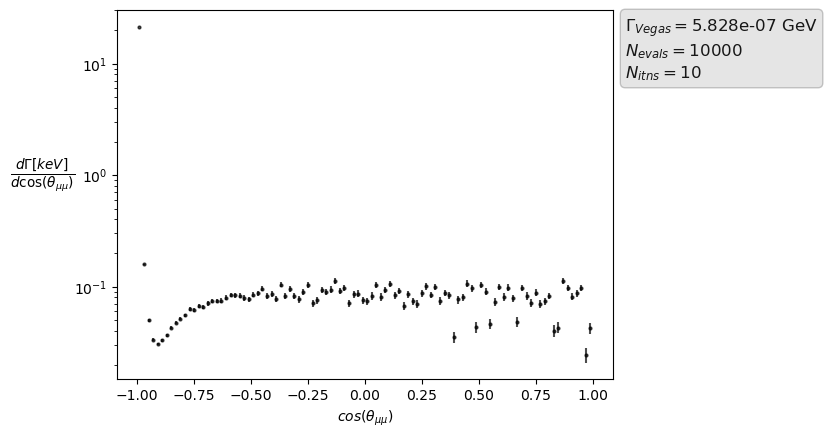

In [33]:
dIs = []
dI_errs = []

cos_s = []
for i in range(0, bins):
    cos_s += [-1 + (i + 0.5) * 2 / bins]
    
for i in range(0, bins):
    dIs += [total_rate['dI_cos_alt'][i].mean]
    dI_errs += [total_rate['dI_cos_alt'][i].sdev]

norm = 2 / bins
keV = 10 ** 6

fig, ax = plt.subplots()

ax.errorbar(cos_s, keV * np.array(dIs) / norm, color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = keV * np.array(dI_errs) / norm)

textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma[keV]}{d\cos(\theta_{\mu\mu})}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$cos(\theta_{\mu\mu})$')
plt.show()

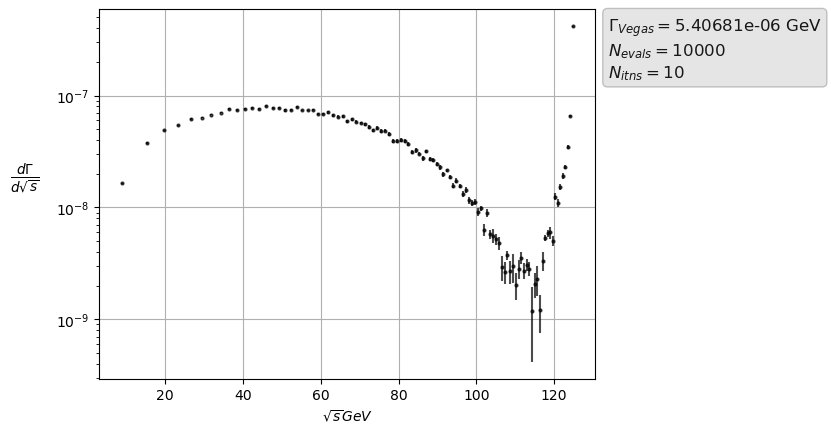

In [10]:
dIs = []
dI_errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dIs += [total_rate['dI'][i].mean / sdbins[i]]
    dI_errs += [total_rate['dI'][i].sdev / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dIs), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

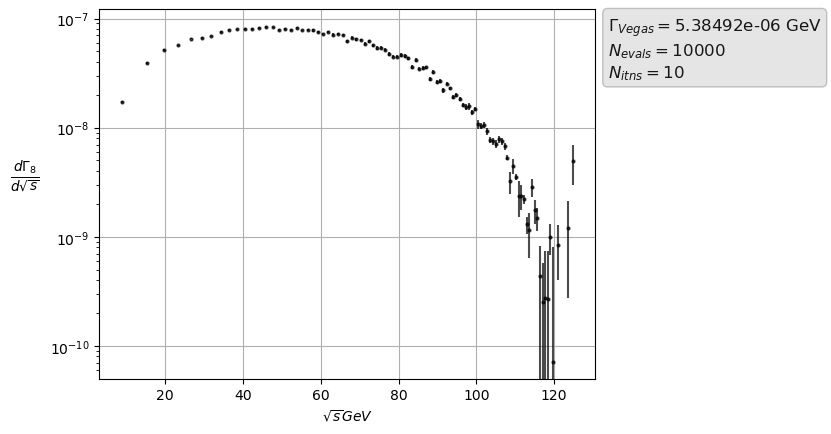

In [11]:
dI_8s = []
dI_8errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_8s += [total_rate['dI_8'][i].mean / sdbins[i]]
    dI_8errs += [total_rate['dI_8'][i].sdev / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_8s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_8errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_8, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{8}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

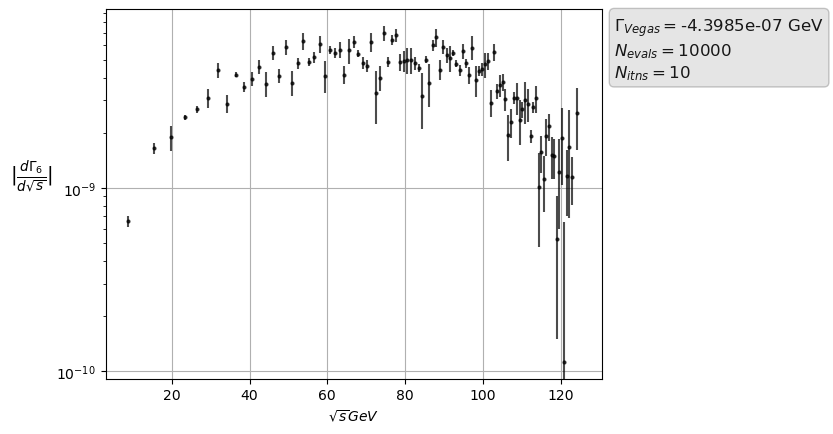

In [12]:
dI_6s = []
dI_6errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_6s += [total_rate['dI_6'][i].mean / sdbins[i]]
    dI_6errs += [total_rate['dI_6'][i].sdev / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, -np.array(dI_6s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_6errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_6, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$|\frac{d\Gamma_{6}}{d\sqrt{s}}|$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

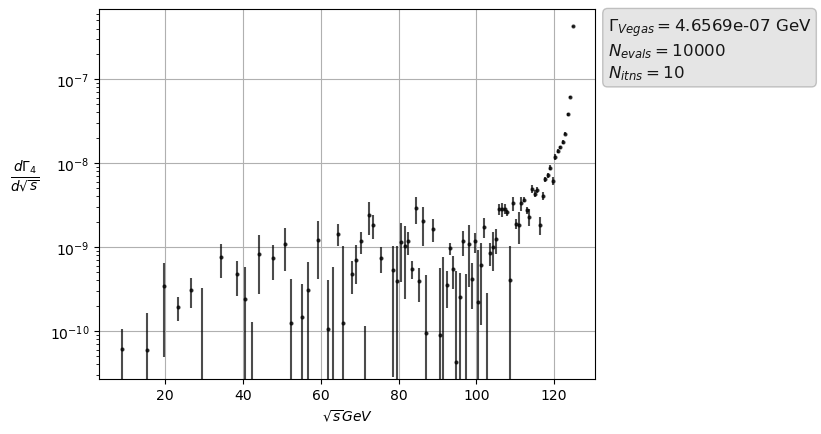

In [13]:
dI_4s = []
dI_4errs = []
sqs = []
ss = []
for i in range(0, bins):
    ss += [s_min_fix + 0.5 * (s_max_fix - s_min_fix) / bins + i * (s_max_fix - s_min_fix) / bins]
    
sbins = []
for i in range(0, bins + 1):
    sbins += [i * (s_max_fix - s_min_fix) / bins]
    
sdbins = []
for i in range(0, bins):
    sdbins += [sbins[i + 1] ** 0.5 - sbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_4s += [total_rate['dI_4'][i].mean / sdbins[i]]
    dI_4errs += [total_rate['dI_4'][i].sdev / sdbins[i]]

sqs = np.array(ss) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dI_4s), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_4errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_4, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma_{4}}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
#plt.ylim(10**-10, 10**-6)
#plt.xlim(0, 130)
plt.show()

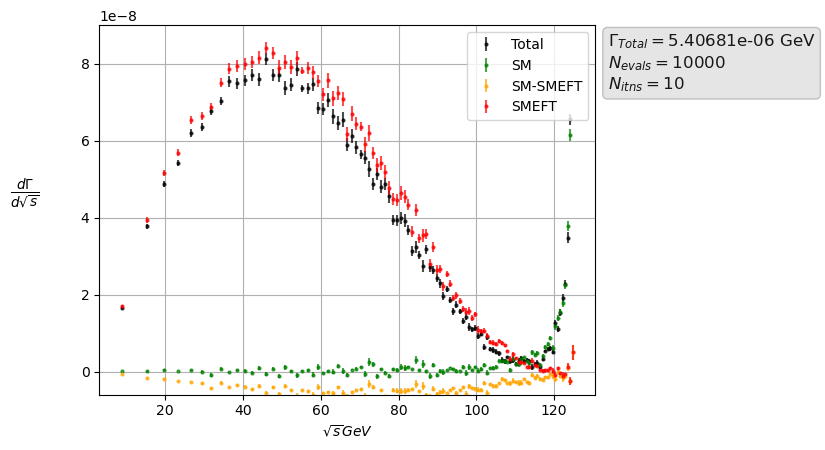

In [17]:
fig, ax = plt.subplots()

ax.errorbar(sqs, np.array(dIs), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_errs))
ax.errorbar(sqs, np.array(dI_4s), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_4errs))
ax.errorbar(sqs, np.array(dI_6s), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_6errs))
ax.errorbar(sqs, np.array(dI_8s), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_8errs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Total}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')

plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{s}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{s} GeV$')
plt.ylim(-6 * 10**-9, 9 * 10**-8)
plt.legend()
#plt.xlim(0, 130)
plt.show()

In [30]:
X

10000

In [ ]:
dI_ts = []
dI_terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_ts += [total_rate['dI_t'][i].mean / tdbins[i]]
    dI_terrs += [total_rate['dI_t'][i].sdev / tdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

In [ ]:
dI_8ts = []
dI_8terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_8ts += [total_rate['dI_8_t'][i].mean / tdbins[i]]
    dI_8terrs += [total_rate['dI_8_t'][i].sdev / tdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_8ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_8terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_8, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{8}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

In [ ]:
dI_6ts = []
dI_6terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_6ts += [total_rate['dI_6_t'][i].mean / tdbins[i]]
    dI_6terrs += [total_rate['dI_6_t'][i].sdev / tdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, -np.array(dI_6ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_6terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_6, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$|\frac{d\Gamma_{6}}{d\sqrt{t}}|$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

In [ ]:
dI_4ts = []
dI_4terrs = []
sqt = []
ts = []
for i in range(0, bins):
    ts += [t_min_fix + 0.5 * (t_max_fix - t_min_fix) / bins + i * (t_max_fix - t_min_fix) / bins]
    
tbins = []
for i in range(0, bins + 1):
    tbins += [i * (t_max_fix - t_min_fix) / bins]
    
tdbins = []
for i in range(0, bins):
    tdbins += [tbins[i + 1] ** 0.5 - tbins[i] ** 0.5]
    
for i in range(0, bins):
    dI_4ts += [total_rate['dI_4_t'][i].mean / tdbins[i]]
    dI_4terrs += [total_rate['dI_4_t'][i].sdev / tdbins[i]]

sqt = np.array(ts) ** 0.5

fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_4ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Vegas', yerr = np.array(dI_4terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed_4, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma_{4}}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
#plt.ylim(10**-11, 10**-6)
#plt.xlim(0, 130)
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.errorbar(sqt, np.array(dI_8ts), color = 'red', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SMEFT', yerr = np.array(dI_8terrs))
ax.errorbar(sqt, np.array(dI_6ts), color = 'orange', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM-SMEFT', yerr = np.array(dI_6terrs))
ax.errorbar(sqt, np.array(dI_4ts), color = 'green', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'SM', yerr = np.array(dI_4terrs))
ax.errorbar(sqt, np.array(dI_ts), color = 'black', alpha = 0.7, 
            ls = 'None', markersize = 4, marker = '.', label = 'Total', yerr = np.array(dI_terrs))

plt.grid()
textstr = '\n'.join((
    r'$\Gamma_{Vegas}=$' +str(round(computed, 11))+ ' GeV',
    r'$N_{evals}=$' +str(nevals)+ '',
    r'$N_{itns}=$' +str(nitns)+ ''))

props = dict(boxstyle='round', facecolor='gray', alpha=0.2)
ax.text(1.025, 0.98, textstr, transform=ax.transAxes, fontsize=12, alpha = 0.9,
        verticalalignment='top', bbox=props)

#plt.yscale('log')
plt.ylabel(r'$\frac{d\Gamma}{d\sqrt{t}}$', rotation = '0', fontsize = 14)
ax.yaxis.set_label_coords(-0.15, 0.5)
plt.xlabel(r'$\sqrt{t} GeV$')
plt.ylim(-10**-8, 8 * 10**-8)
#plt.xlim(0, 130)
plt.legend()
plt.show()